# Simple network from scratch

In [30]:
from __future__ import print_function

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dropout, Dense, Activation, Conv2D, MaxPooling2D, Flatten

from keras.optimizers import SGD
from keras import backend as K

import pandas as pd
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

# image processing 
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
from scipy.misc import imresize
import matplotlib.image as mpimg

# Load data

In [37]:
############# Read in data ################

train = pd.read_csv('../data/train_data_with_sampling.csv')
test = pd.read_csv('../data/test_data.csv')

############# Convert to test and train set ################

X_train_ids = train[['tmdb_id']].values
y_train = train[['group1', 'group2', 'group3', 'group4', 'group5', 'group6', 'group7']].as_matrix()
X_test_ids = test[['tmdb_id']].values
y_test = test[['group1', 'group2', 'group3', 'group4', 'group5', 'group6', 'group7']].as_matrix()

############# Function to convert color to grayscale ################

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

############## Function to read file from github given tmdb id ###################

def loadImageFromId(tmdb_id):
    url = 'https://raw.githubusercontent.com/nikhilaravi/movies/master/posters/' + tmdb_id + '.jpg'
    file = io.BytesIO(urllib.request.urlopen(url).read())
    img = Image.open(file)
    return img

############# Load in posters ################

def load_posters_from_ids(id_array, n, y):
    start = np.random.choice(range(len(id_array)-n))
    end = start + n
    posters = []
    ids = []
    errors = 0
    for poster in id_array[start:end]:
        # comment out the first this line if running locally and uncomment the second line
        img = loadImageFromId(str(int(poster[0])))
        # img = Image.open('../posters/' + str(int(poster[0])) + '.jpg') 
        try:
            scaled = img.resize(size=(500, 741))
            posters.append(np.asarray(scaled))
            ids.append(poster)
        except ValueError:
            errors +=1
            continue
    posters_array = np.asarray(posters)
    X = np.array(posters_array)
    
    Y = y[:n]
    print ('posters shape: ', X.shape)
    print ('errors: ', errors)
    return X, Y

In [72]:
X_train, Y_train = load_posters_from_ids(X_train_ids, 500, y_train)
X_test, Y_test = load_posters_from_ids(X_test_ids, 100, y_test)

posters shape:  (500, 741, 500, 3)
errors:  0
posters shape:  (100, 741, 500, 3)
errors:  0


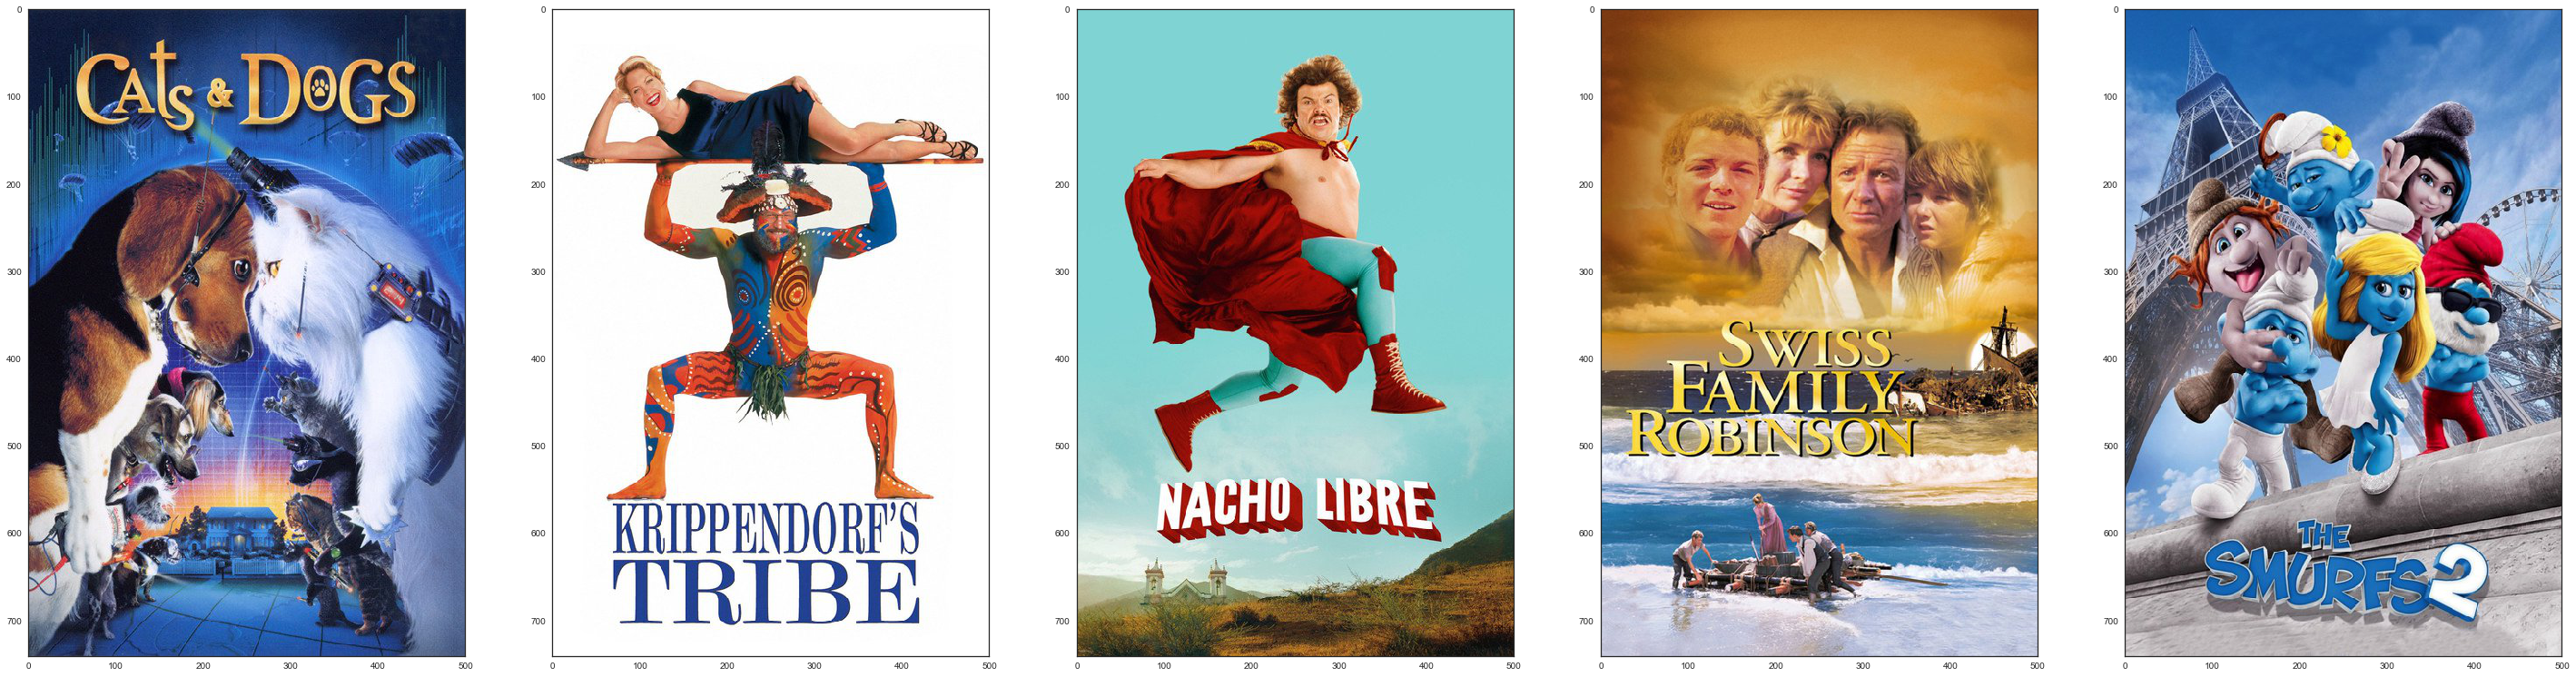

In [73]:
############# Visualise first 5 images of training set ################

plt.figure(figsize=(50,50))
for i in range(1,6):
    plt.subplot(1, 5, i)
    plt.imshow(X_train[i])

# 3 conv max pool layers and 2 fully connected output layers

In [74]:
####### Model ##########

model = Sequential()
model.add(Conv2D(32, (3,3), input_shape=(741, 500, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3,3)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# output is a 3D feature map (height, width, features)

# add two fully connected output layers

model.add(Flatten()) # 1D feature vector
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(7))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
             optimizer='rmsprop', 
             metrics=['accuracy'])

In [75]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 739, 498, 32)      896       
_________________________________________________________________
activation_40 (Activation)   (None, 739, 498, 32)      0         
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 246, 166, 32)      0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 244, 164, 32)      9248      
_________________________________________________________________
activation_41 (Activation)   (None, 244, 164, 32)      0         
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 122, 82, 32)       0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 120, 80, 64)       18496     
__________

In [ ]:
batch_size = 16
epochs = 50
history = model.fit(X_train, Y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)

# once training is complete, let's see how well we have done
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/50
500/500 [==============================] - 279s - loss: 4.0450 - acc: 0.7429   
Epoch 2/50
500/500 [==============================] - 251s - loss: 2.8239 - acc: 0.8231   
Epoch 3/50
500/500 [==============================] - 302s - loss: 2.6852 - acc: 0.8320   
Epoch 4/50
500/500 [==============================] - 317s - loss: 2.6057 - acc: 0.8369   
Epoch 5/50
500/500 [==============================] - 249s - loss: 2.7397 - acc: 0.8286   
Epoch 6/50
400/500 [=======================>......] - ETA: 54s - loss: 2.8052 - acc: 0.8243

In [60]:
# These are how we measure error - Haming Loss, % exact matches and % at-least-one match
from sklearn.metrics import hamming_loss

def error_measures(ypred, ytest):
    ypred = np.array(ypred)
    ytest = np.array(ytest)
    
    # Hamming loss
    h_loss = hamming_loss(ytest, ypred)

    # Percent exact matches
    y_pred_str = np.array([str(yi) for yi in ypred])
    y_test_str = np.array([str(yi) for yi in ytest])
    percent_exact = np.sum(y_pred_str == y_test_str) * 1. / ytest.shape[0]
    
    # Percent at least one match (at least one of the genres are both 1)
    atleastone_count = 0
    for ind in range(len(ypred)):
        yi_pred = ypred[ind]
        yi_test = ytest[ind]
        for i in range(len(yi_pred)):
            if yi_pred[i] == 1 and yi_test[i] == 1:
                atleastone_count += 1
                break
    percent_atleastone = atleastone_count * 1. / ytest.shape[0]
    
    return h_loss, percent_exact, percent_atleastone

In [61]:
y_pred = model.predict(X_test)

In [63]:
error_measures(y_pred, Y_test)

(0.14857142857142858, 0.0, 1.0)

In [68]:
np.sum(Y_test, axis=0)

array([50, 40,  0,  0,  6, 23,  9])

In [70]:
np.sum(y_pred, axis=0)

array([ 50.,  50.,   0.,   0.,   0.,  50.,   0.], dtype=float32)